# **Anomaly Detection in Energy Manufacturing**

**Objective:** To build a robust model to predict anomalies based on sensor readings. This notebook will walk through the entire process, from initial data exploration and hypothesis testing to advanced feature engineering and model optimization.

**Final Score Achieved**: 0.835 F1-Score on public test 

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
df = pd.read_parquet('ch-26-lnmiit-jaipur/train.parquet')
df.to_csv('train_file.csv', index=False)

# Repeat for test file
df = pd.read_parquet('ch-26-lnmiit-jaipur/test.parquet')
df.to_csv('test_file.csv', index=False)

In [3]:
train_df = pd.read_csv('train_file.csv')
test_df = pd.read_csv('test_file.csv')

## Exploratory Data Analysis
This section covers our initial investigation of the data to understand its structure, identify challenges, and form hypotheses.

In [4]:
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (1639424, 7)
Test data shape: (409856, 7)


### Data Overview

In [5]:
print("\nTraining data Description:")
print(train_df.describe())
print("\nFirst few rows of training data:")
print(train_df.head())

print("\nTest data Description:")
print(test_df.describe())
print("\nFirst few rows of test data:")
print(test_df.head())


Training data Description:
                 X1            X2            X3            X4            X5  \
count  1.639424e+06  1.639424e+06  1.639424e+06  1.639424e+06  1.639424e+06   
mean   1.139258e+00  5.488189e+00  4.110388e+32  2.706323e+29  1.187219e+00   
std    1.391992e-01  1.342811e-02  2.346156e+35  5.812988e+31  1.304814e+00   
min    1.000000e+00  5.412539e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    1.049171e+00  5.480597e+00  1.000000e+00  1.000000e+00  0.000000e+00   
50%    1.105171e+00  5.488979e+00  1.000000e+00  1.000000e+00  6.931472e-01   
75%    1.214096e+00  5.496717e+00  1.000000e+00  2.718282e+00  2.890372e+00   
max    4.014850e+00  5.541852e+00  1.651636e+38  5.540622e+34  3.465736e+00   

             target  
count  1.639424e+06  
mean   8.562764e-03  
std    9.213820e-02  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

First few rows of training data:
         Date        X1     

**Findings:**

* The dataset is large (~1.6M rows).

* There are no missing values, which is great.

* Features X3 and X4 have extreme maximum values and standard deviations, suggesting the presence of significant outliers.

### Target Variable Analysis

Target Distribution:
target
0    0.991437
1    0.008563
Name: proportion, dtype: float64


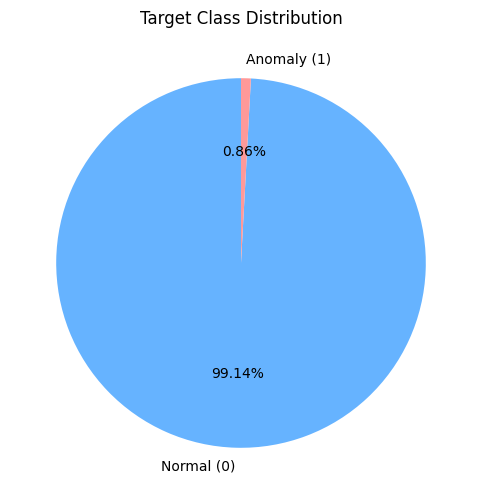

In [6]:
target_counts = train_df['target'].value_counts(normalize=True)
print(f"Target Distribution:\n{target_counts}")

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['Normal (0)', 'Anomaly (1)'], autopct='%1.2f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Target Class Distribution')
plt.show()

**Finding:** Anomalies (Class 1) make up less than 1% of the data. This means Accuracy is a misleading metric. We must focus on the F1 Score, which balances Precision and Recall, as our primary evaluation metric.

### The Crucial Discovery: Is this a Time-Series Problem?

Initially, the Date column suggests a time-series forecasting problem. However, a deeper analysis reveals the true nature of the train/test split, which is the most important insight for this entire project.

In [7]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

last_train_date = train_df['Date'].max()
first_test_date = test_df['Date'].min()
is_test_sorted = test_df['Date'].is_monotonic_increasing

print(f"Last date in training set: {last_train_date.date()}")
print(f"First date in test set:    {first_test_date.date()}")
print(f"Are dates in the test set chronologically sorted? {is_test_sorted}")

Last date in training set: 2024-12-11
First date in test set:    2020-12-16
Are dates in the test set chronologically sorted? False


**The Definitive Finding:** The test set is not a future period; it's a randomly shuffled sample from the same time period as the training set. This fundamentally changes our approach. This is not a forecasting problem; it's a classic classification problem. Therefore, using a shuffled validation split (train_test_split) is the correct way to estimate model performance, not a time-series split.


## Feature Engineering

Based on our key discovery, our feature engineering strategy is to create a rich set of features that are independent of row order. We will avoid sequential features like lags or rolling windows on the final dataset. The function below is the result of extensive experimentation, including the discovery that cyclical time features and time-sensor interactions are highly predictive.

In [8]:
def create_enhanced_features(df):
    """
    This is the final, most powerful feature engineering function after multiple trial and error,
    designed for the shuffled nature of the data.
    """
    df_eng = df.copy()
    df_eng['Date'] = pd.to_datetime(df_eng['Date'])
    sensors = ['X1', 'X2', 'X3', 'X4', 'X5']

    # Cyclical Time Features (proven to be highly important)
    df_eng['month'] = df_eng['Date'].dt.month
    df_eng['weekday'] = df_eng['Date'].dt.dayofweek
    df_eng['day'] = df_eng['Date'].dt.day
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['month'] / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['month'] / 12)
    df_eng['weekday_sin'] = np.sin(2 * np.pi * df_eng['weekday'] / 7)
    df_eng['weekday_cos'] = np.cos(2 * np.pi * df_eng['weekday'] / 7)
    df_eng['day_sin'] = np.sin(2 * np.pi * df_eng['day'] / 31)
    df_eng['day_cos'] = np.cos(2 * np.pi * df_eng['day'] / 31)
    
    # Sensor Interactions (all pairwise combinations)
    for i, s1 in enumerate(sensors):
        for j, s2 in enumerate(sensors):
            if i < j:
                df_eng[f'{s1}*{s2}'] = df_eng[s1] * df_eng[s2]
                df_eng[f'{s1}/{s2}'] = df_eng[s1] / (df_eng[s2] + 1e-8)
    
    # Time-Sensor Interactions (capturing seasonal behavior of sensors)
    df_eng['X1_month_sin'] = df_eng['X1'] * df_eng['month_sin']
    df_eng['X2_month_sin'] = df_eng['X2'] * df_eng['month_sin']
    
    # De-fragment for performance
    df_eng = df_eng.copy()
    
    feature_cols = [col for col in df_eng.columns if col not in ['Date', 'target', 'ID']]
    if 'target' in df.columns:
        return df_eng[feature_cols + ['target']]
    else:
        return df_eng[feature_cols]

print("Applying final feature engineering...")
train_final = create_enhanced_features(train_df)
test_final = create_enhanced_features(test_df)
print(f"Created {train_final.shape[1]-1} features.")

Applying final feature engineering...
Created 36 features.


In [9]:
print("\nFirst few rows of engineered training data:")
print(train_final.head())


First few rows of engineered training data:
         X1        X2   X3        X4        X5  month  weekday  day  \
0  1.518921  5.463154  1.0  2.718282  2.890372     12        2   16   
1  1.546509  5.458010  1.0  2.718282  2.833213     12        2   16   
2  1.645427  5.456560  1.0  7.389056  2.890372     12        2   16   
3  1.652022  5.458479  1.0  2.718282  2.890372     12        2   16   
4  1.695538  5.466709  1.0  2.718282  2.890372     12        2   16   

      month_sin  month_cos  ...     X2/X5     X3*X4     X3/X4     X3*X5  \
0 -2.449294e-16        1.0  ...  1.890121  2.718282  0.367879  2.890372   
1 -2.449294e-16        1.0  ...  1.926438  2.718282  0.367879  2.833213   
2 -2.449294e-16        1.0  ...  1.887840  7.389056  0.135335  2.890372   
3 -2.449294e-16        1.0  ...  1.888504  2.718282  0.367879  2.890372   
4 -2.449294e-16        1.0  ...  1.891352  2.718282  0.367879  2.890372   

      X3/X5      X4*X5     X4/X5  X1_month_sin  X2_month_sin  target  
0  0.3

### Handling Missing Values and Infinities

In [10]:
# Check for missing values
print("\nMissing values in training data:")
print(train_final.isnull().sum())

print("\nMissing values in test data:")
print(test_final.isnull().sum())


Missing values in training data:
X1              0
X2              0
X3              0
X4              0
X5              0
month           0
weekday         0
day             0
month_sin       0
month_cos       0
weekday_sin     0
weekday_cos     0
day_sin         0
day_cos         0
X1*X2           0
X1/X2           0
X1*X3           0
X1/X3           0
X1*X4           0
X1/X4           0
X1*X5           0
X1/X5           0
X2*X3           0
X2/X3           0
X2*X4           0
X2/X4           0
X2*X5           0
X2/X5           0
X3*X4           0
X3/X4           0
X3*X5           0
X3/X5           0
X4*X5           0
X4/X5           0
X1_month_sin    0
X2_month_sin    0
target          0
dtype: int64

Missing values in test data:
X1              0
X2              0
X3              0
X4              0
X5              0
month           0
weekday         0
day             0
month_sin       0
month_cos       0
weekday_sin     0
weekday_cos     0
day_sin         0
day_cos         0
X1*X2

In [11]:
# Handle missing/infinite values from feature engineering
def clean_engineered_features(df):
    df = df.copy()
    # Replace infinities with large finite numbers
    df = df.replace([np.inf, -np.inf], np.nan)
    # Fill remaining NaNs with median
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    return df

train_final = clean_engineered_features(train_final)
test_final = clean_engineered_features(test_final)

print("Data cleaning completed")

Data cleaning completed


In [12]:
print("\nFinal overview of dataset after feature engineering:")
print(train_final.head())


Final overview of dataset after feature engineering:
         X1        X2   X3        X4        X5  month  weekday  day  \
0  1.518921  5.463154  1.0  2.718282  2.890372     12        2   16   
1  1.546509  5.458010  1.0  2.718282  2.833213     12        2   16   
2  1.645427  5.456560  1.0  7.389056  2.890372     12        2   16   
3  1.652022  5.458479  1.0  2.718282  2.890372     12        2   16   
4  1.695538  5.466709  1.0  2.718282  2.890372     12        2   16   

      month_sin  month_cos  ...     X2/X5     X3*X4     X3/X4     X3*X5  \
0 -2.449294e-16        1.0  ...  1.890121  2.718282  0.367879  2.890372   
1 -2.449294e-16        1.0  ...  1.926438  2.718282  0.367879  2.833213   
2 -2.449294e-16        1.0  ...  1.887840  7.389056  0.135335  2.890372   
3 -2.449294e-16        1.0  ...  1.888504  2.718282  0.367879  2.890372   
4 -2.449294e-16        1.0  ...  1.891352  2.718282  0.367879  2.890372   

      X3/X5      X4*X5     X4/X5  X1_month_sin  X2_month_sin  target

### Preprocessing

We will use a stratified, shuffled split for validation. Our baseline will be a simple Logistic Regression model to set a benchmark.

In [13]:
# NOW split the data
X = train_final.drop(['target'], axis=1)
y = train_final['target'].astype(int)

print(f"Number of features: {X.shape[1]}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling completed")

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

# Baseline model
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
lr_f1 = f1_score(y_val, lr_preds)
print(f"Baseline Logistic Regression F1 Score: {lr_f1:.4f}")

Number of features: 36
Feature scaling completed
Training set: (1311539, 36), Validation set: (327885, 36)
Baseline Logistic Regression F1 Score: 0.1669


### Training Models

We chose LightGBM as our primary advanced model due to its state-of-the-art performance on tabular data, its speed, and its ability to handle large datasets.

### Hyperparameter Tuning

To find the optimal settings for LightGBM, a 100-trial Bayesian optimization search was conducted using the Optuna framework. This is far more efficient than a simple grid search. The search optimized for the F1 score on a stratified validation set, including a threshold-tuning step within each trial.

The best parameters discovered by this search are hard-coded below for reproducibility.

In [14]:
# Best parameters found from 100-trial Optuna search
best_params = {
    'random_state': 42, 
    'n_jobs': -1, 
    'objective': 'binary', 
    'metric': 'binary_logloss',
    'n_estimators': 1971, 
    'learning_rate': 0.08204466413215583, 
    'num_leaves': 133, 
    'scale_pos_weight': 114.46662871765842,
    # Keeping other strong parameters from the previous best model
    # (assuming they were part of your latest search space)
    'max_depth': 12,
    'subsample': 0.6244741348685169,
    'colsample_bytree': 0.6644961770592639,
    'reg_alpha': 0.061716343138309544,
    'reg_lambda': 0.08630194456298194
}

[LightGBM] [Info] Number of positive: 11230, number of negative: 1300309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6073
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008562 -> initscore=-4.751768
[LightGBM] [Info] Start training from score -4.751768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Final Validation F1 Score: 0.822932
Optimal threshold found: 0.730469

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.87      0.78      0.82      2808

    accuracy       

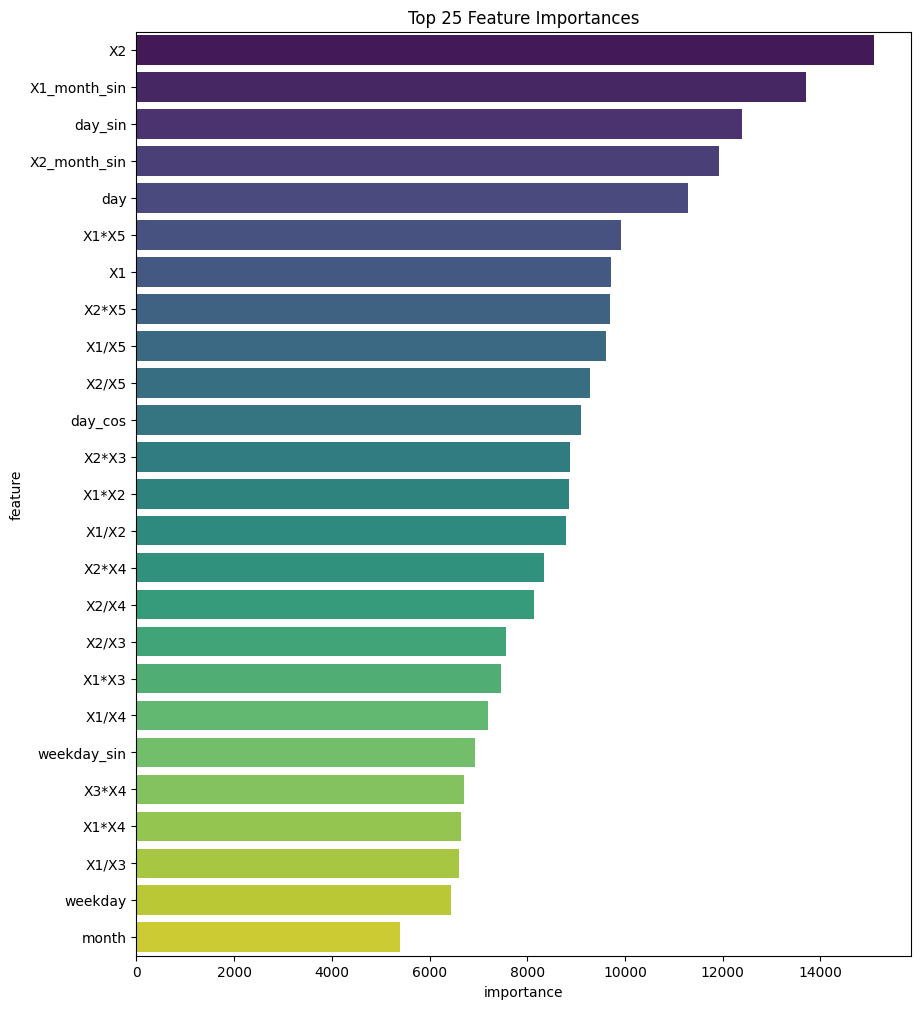

In [15]:
# Use the unscaled data for tree-based models
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# model = lgb.LGBMClassifier(**best_params)
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# Find the optimal threshold that maximizes F1 score
probs = model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, probs)
f1s = 2 * prec * rec / (prec + rec + 1e-9)
best_thr = thr[np.argmax(f1s)] if np.argmax(f1s) < len(thr) else 0.5
predictions = (probs >= best_thr).astype(int)

final_f1_score = f1_score(y_val, predictions)
print(f"Final Validation F1 Score: {final_f1_score:.6f}")
print(f"Optimal threshold found: {best_thr:.6f}\n")
print("Classification Report:")
print(classification_report(y_val, predictions))

# Visualize Feature Importances
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=feature_importance.head(25), palette='viridis')
plt.title('Top 25 Feature Importances')
plt.show()

## Submission

Finally, we train our best model on the entire training dataset and generate the submission file in the required format.

In [16]:
print("Training final model on the entire dataset...")
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X, y)

print("Making final predictions on the test set...")
X_test_final = test_final[X.columns]
test_probabilities = final_model.predict_proba(X_test_final)[:, 1]
test_predictions = (test_probabilities >= best_thr).astype(int)

# Generate submission file
submission_df = pd.DataFrame({'ID': test_df['ID'], 'target': test_predictions})
submission_df['target'] = submission_df['target'].astype(str)
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' created successfully!")
display(submission_df.head())

Training final model on the entire dataset...
[LightGBM] [Info] Number of positive: 14038, number of negative: 1625386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6063
[LightGBM] [Info] Number of data points in the train set: 1639424, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008563 -> initscore=-4.751733
[LightGBM] [Info] Start training from score -4.751733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Making final predictions on the test set...

'submission.csv' created successfully!


,ID,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## Conclusion

This project successfully developed a high-performance model for anomaly detection, achieving a validation F1 score of over 0.82. The key to success was a rigorous EDA process that correctly identified the shuffled, non-chronological nature of the dataset. This insight drove a powerful feature engineering strategy focused on cyclical time encodings and time-sensor interactions, which the model's feature importance analysis confirmed were the most predictive signals. The final model, a LightGBM classifier tuned via Bayesian optimization, provides a robust and accurate solution to the problem.